In [1]:
import json
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Added Features:
- `readout_match`: Binary feature; 1 if the logical readout (L) matches the expected readout, otherwise 0.
- `index_flip`: Eight columns (index_flip_0 to index_flip_7), representing the number of bit flips for each index between the three rounds.
- `agreement`: Proportion of bits that agree across all three rounds for each row.
- `flip_errs`: Count of the number of errors (1s) in the last four bits (Z3, Z2, Z1, Z0) of each round, where these bits should always be zero.

In [2]:
import json

# File paths for the JSON files
json_files = [
    'data/json/qubit1Z_d3_a1_results.json',
    'data/json/qubit1Z_d3_a2_results.json',
    'data/json/qubit1Z_d3_b1_results.json'
]

# Output file path for the concatenated results
output_file = 'data/json/qubit1Z_d3_combined_results.json'

# Function to load a JSON file
def load_json_data(file_path):
    try:
        with open(file_path, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return {}

# Main script to concatenate JSON files
if __name__ == "__main__":
    # Create an empty dictionary to store the concatenated data
    combined_data = {}

    # Loop over each JSON file and update the combined data
    for file_path in json_files:
        json_data = load_json_data(file_path)
        
        # Merge the json_data with combined_data
        for backend, data in json_data.items():
            if backend in combined_data:
                combined_data[backend].update(data)  # Update existing backend data
            else:
                combined_data[backend] = data  # Add new backend data
    
    # Save the combined data to a new JSON file
    with open(output_file, 'w') as f:
        json.dump(combined_data, f, indent=4)

    print(f"Data has been successfully concatenated into {output_file}.")

Data has been successfully concatenated into data/json/qubit1Z_d3_combined_results.json.


In [3]:
def json_to_expanded_df(json_file, d = 5, num_rounds = 3):
    with open(json_file, 'r') as f:
        data = json.load(f)

    def process_data(data):
        rows = []
        for backend, results in data.items():
            for key, count in results.items():
                split_data = key.split()  # Split based on space
                readout = int(split_data[0])  # L value (Z readout)
                bitstrings = split_data[1:]  # Remaining are the rounds

                # Flatten the bitstrings into individual bits
                expanded_bits = [int(bit) for bitstring in bitstrings for bit in bitstring]
                
                # Append backend, expanded bits, readout, and count
                rows.append([backend] + expanded_bits + [readout, count])

        return rows

    # Dynamically generate column names based on the bitstring length
    measure_bits = (d*d)-1  # 24 bits per round of d=5

    columns = ['backend']
    for r in range(num_rounds):
        for q in range(measure_bits):
            columns.append(f'bit_{q}_round_{r}')

    columns += ['z_readout', 'count']
    return pd.DataFrame(process_data(data), columns=columns)

def calculate_index_flip(row, measure_bits):
    """Calculate the number of flips for each bit between rounds."""
    flips = []
    
    # Iterate through the measure_bits bits 
    for i in range(measure_bits):
        # Check flips between round_0, round_1, and round_2
        bit_r0 = row[f'bit_{i}_round_0']
        bit_r1 = row[f'bit_{i}_round_1']
        bit_r2 = row[f'bit_{i}_round_2']
        
        # Count the flips between consecutive rounds
        flip_count = (bit_r0 != bit_r1) + (bit_r1 != bit_r2)
        flips.append(flip_count)
    
    return flips

def calculate_agreement(row, measure_bits):
    """Calculate the agreement between rounds for each bit."""
    agreement_count = 0

    # Iterate through the measure_bits bits and check if they agree across rounds
    for i in range(measure_bits):
        bit_r0 = row[f'bit_{i}_round_0']
        bit_r1 = row[f'bit_{i}_round_1']
        bit_r2 = row[f'bit_{i}_round_2']
        
        # Check if the bits are the same in all rounds
        if bit_r0 == bit_r1 == bit_r2:
            agreement_count += 1

    return agreement_count / measure_bits  # Proportion of agreement

def calculate_flip_errs(row, measure_bits):
    """
    Calculate the number of errors (1s) in the last measure_bits/2 bits of each round.

    Parameters:
    row: The row containing the bits data.
    measure_bits: The total number of measurement bits. 
                  The function will check the last measure_bits/2 bits for errors.
    """
    flip_errs = 0
    half_measure_bits = measure_bits // 2  # Calculate half of measure_bits

    # Iterate through the last half_measure_bits bits for each round
    for i in range(measure_bits - half_measure_bits, measure_bits):
        flip_errs += row[f'bit_{i}_round_0']
        flip_errs += row[f'bit_{i}_round_1']
        flip_errs += row[f'bit_{i}_round_2']

    return flip_errs

In [4]:
def build_backend_classifier(df, expected_readout=0, d=5):
    measure_bits = (d*d)-1
    
    df = df[df['backend'] != 'ibm_sherbrooke_a2'].copy()  # Ensure we're working on a copy
    df = df[df['backend'] != 'ibm_brisbane_a2'].copy()
    df = df[df['backend'] != 'ibm_kyiv_a2'].copy()
    
    # readout_match (1 if z_readout matches expected_readout, else 0)
    df['readout_match'] = (df['z_readout'] == expected_readout).astype(int)
    
    # index_flip (how many times each bit flips between rounds)
    index_flip_cols = [f'index_flip_{i}' for i in range(measure_bits)]
    
    # index_flip_cols (flips between rounds)
    df[index_flip_cols] = df.apply(lambda row: calculate_index_flip(row, measure_bits), axis=1, result_type='expand')

    # agreement (proportion of bits that agree across rounds)
    df['agreement'] = df.apply(lambda row: calculate_agreement(row, measure_bits), axis=1)

    # flip_errs (count of errors in the last measure_bits/2 bits of each round)
    df['flip_errs'] = df.apply(lambda row: calculate_flip_errs(row, measure_bits), axis=1)
    
    # Select features for training (excluding backend and count)
    X = df.drop(columns=['backend', 'count'])
    y = df['backend']  # Target
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create and train the RandomForestClassifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    # Predictions and evaluation
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Output accuracy and classification report
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf, df, y_test, y_pred

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [6]:
def build_binary_backend_classifier(df, expected_readout=0, d=5, target_backend='ibm_brisbane'):
    measure_bits = (d*d)-1
    df = df[df['backend'] != 'ibm_sherbrooke_a2'].copy()  # Ensure we're working on a copy
    df = df[df['backend'] != 'ibm_brisbane_a2'].copy()
    df = df[df['backend'] != 'ibm_kyiv_a2'].copy()
    
    # readout_match (1 if z_readout matches expected_readout, else 0)
    df['readout_match'] = (df['z_readout'] == expected_readout).astype(int)
    
    # index_flip (how many times each bit flips between rounds)
    index_flip_cols = [f'index_flip_{i}' for i in range(measure_bits)]
    
    # index_flip_cols (flips between rounds)
    df[index_flip_cols] = df.apply(lambda row: calculate_index_flip(row, measure_bits), axis=1, result_type='expand')

    # agreement (proportion of bits that agree across rounds)
    df['agreement'] = df.apply(lambda row: calculate_agreement(row, measure_bits), axis=1)

    # flip_errs (count of errors in the last measure_bits/2 bits of each round)
    df['flip_errs'] = df.apply(lambda row: calculate_flip_errs(row, measure_bits), axis=1)
    
    # Convert the 'backend' column to binary (1 for target_backend, 0 for others)
    df['binary_backend'] = (df['backend'] == target_backend).astype(int)
    
    # Select features for training (excluding original backend and count columns)
    X = df.drop(columns=['backend', 'count', 'binary_backend'])
    y = df['binary_backend']  # Binary target variable
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create and train the RandomForestClassifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    # Predictions and evaluation
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Output accuracy and classification report
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf, df, y_test, y_pred

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE  # Optionally use SMOTE for oversampling

def build_binary_backend_classifier(df, expected_readout=0, d=5, target_backend='ibm_brisbane', adjust_threshold=False, threshold=0.5):
    measure_bits = (d*d)-1
    df = df[df['backend'] != 'ibm_sherbrooke_a2'].copy()  # Ensure we're working on a copy
    df = df[df['backend'] != 'ibm_brisbane_a2'].copy()
    df = df[df['backend'] != 'ibm_kyiv_a2'].copy()
    
    # readout_match (1 if z_readout matches expected_readout, else 0)
    df['readout_match'] = (df['z_readout'] == expected_readout).astype(int)
    
    # index_flip (how many times each bit flips between rounds)
    index_flip_cols = [f'index_flip_{i}' for i in range(measure_bits)]
    
    # index_flip_cols (flips between rounds)
    df[index_flip_cols] = df.apply(lambda row: calculate_index_flip(row, measure_bits), axis=1, result_type='expand')

    # agreement (proportion of bits that agree across rounds)
    df['agreement'] = df.apply(lambda row: calculate_agreement(row, measure_bits), axis=1)

    # flip_errs (count of errors in the last measure_bits/2 bits of each round)
    df['flip_errs'] = df.apply(lambda row: calculate_flip_errs(row, measure_bits), axis=1)
    
    # Convert the 'backend' column to binary (1 for target_backend, 0 for others)
    df['binary_backend'] = (df['backend'] == target_backend).astype(int)
    
    # Select features for training (excluding original backend and count columns)
    X = df.drop(columns=['backend', 'count', 'binary_backend'])
    y = df['binary_backend']  # Binary target variable
    
    # Optionally apply SMOTE for oversampling the minority class (1s)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    
    # Create and train the RandomForestClassifier with class_weight='balanced'
    clf = RandomForestClassifier(random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    # Predictions and evaluation with option to adjust threshold
    y_proba = clf.predict_proba(X_test)[:, 1]  # Get probability estimates for class 1
    if adjust_threshold:
        y_pred = (y_proba >= threshold).astype(int)  # Apply custom threshold for classification
    else:
        y_pred = clf.predict(X_test)  # Use default threshold of 0.5
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Output accuracy, classification report, and AUC score
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Optionally output precision-recall curve for further analysis
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    
    return clf, df, y_test, y_pred, precision, recall, thresholds


## d=3

In [ ]:
# qubit1Z_d3_state.pkl : qubit1Z_d3_{backend}_transpiled.qpy (at time of creation)
json_file = 'data/json/qubit1Z_d3_results.json'
df = json_to_expanded_df(json_file, d=3)
clf, updated_df, y_test, y_pred = build_backend_classifier(df, d=3)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

Accuracy: 49.31%
Classification Report:
                precision    recall  f1-score   support

  ibm_brisbane       0.45      0.40      0.42      1525
      ibm_kyiv       0.56      0.62      0.59      1498
ibm_sherbrooke       0.46      0.46      0.46      1477

      accuracy                           0.49      4500
     macro avg       0.49      0.49      0.49      4500
  weighted avg       0.49      0.49      0.49      4500



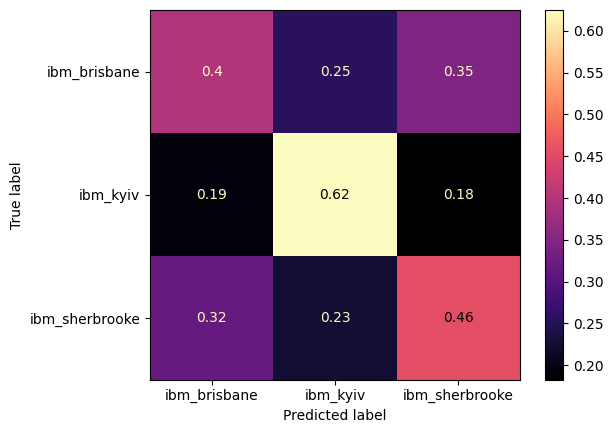

In [5]:
# qubit1Z_d3_state.pkl : qubit1Z_d3_{backend}_transpiled.qpy (1 week later)
json_file = 'data/json/qubit1Z_d3_2_results.json'
df = json_to_expanded_df(json_file, d=3)
clf, updated_df, y_test, y_pred = build_backend_classifier(df, d=3)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

Accuracy: 51.03%
Classification Report:
                precision    recall  f1-score   support

  ibm_brisbane       0.57      0.58      0.57      1499
      ibm_kyiv       0.51      0.53      0.52      1524
ibm_sherbrooke       0.45      0.43      0.44      1476

      accuracy                           0.51      4499
     macro avg       0.51      0.51      0.51      4499
  weighted avg       0.51      0.51      0.51      4499



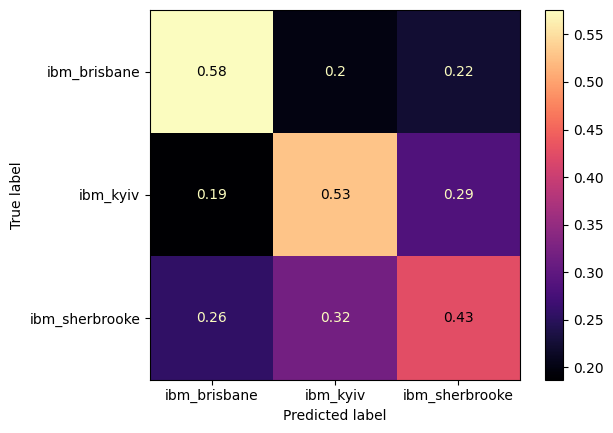

In [7]:
# qubit1Z_d3_state.pkl : qubit1Z_d3_{backend}_transpiled.qpy (1 week later)
json_file = 'data/json/qubit1Z_d3_b_results.json'
df = json_to_expanded_df(json_file, d=3)
clf, updated_df, y_test, y_pred = build_backend_classifier(df, d=3)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

In [57]:
json_file = 'data/json/qubit1Z_d3_combined_results.json'
df = json_to_expanded_df(json_file, d=3)
clf, updated_df, y_test, y_pred = build_backend_classifier(df, d=3)

Accuracy: 34.45%
Classification Report:
                   precision    recall  f1-score   support

  ibm_brisbane_a1       0.42      0.47      0.45      1541
  ibm_brisbane_b1       0.37      0.40      0.38      1488
      ibm_kyiv_a1       0.38      0.43      0.40      1505
      ibm_kyiv_b1       0.28      0.28      0.28      1479
ibm_sherbrooke_a1       0.31      0.24      0.27      1494
ibm_sherbrooke_b1       0.28      0.25      0.26      1491

         accuracy                           0.34      8998
        macro avg       0.34      0.34      0.34      8998
     weighted avg       0.34      0.34      0.34      8998



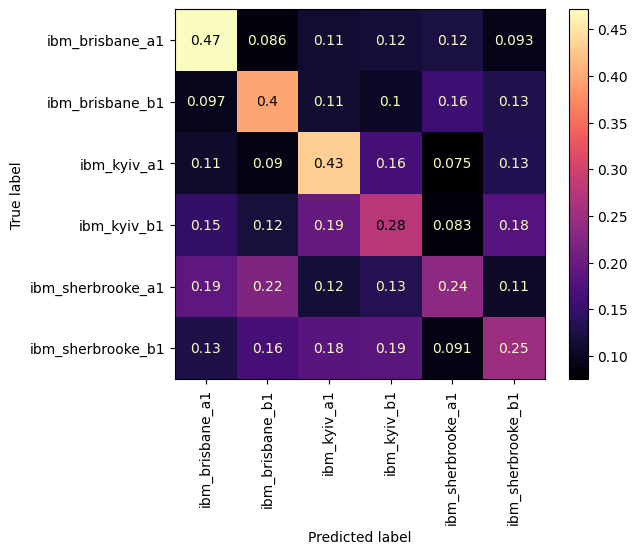

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')
plt.xticks(rotation=90)
plt.savefig('qubit1Z_d3_combined_matrix_diffmaps.png', dpi=300, bbox_inches='tight')
plt.show()

## d=5

Accuracy: 76.67%
Classification Report:
                precision    recall  f1-score   support

  ibm_brisbane       0.74      0.70      0.72      1492
      ibm_kyiv       0.79      0.84      0.82      1484
ibm_sherbrooke       0.76      0.76      0.76      1524

      accuracy                           0.77      4500
     macro avg       0.77      0.77      0.77      4500
  weighted avg       0.77      0.77      0.77      4500



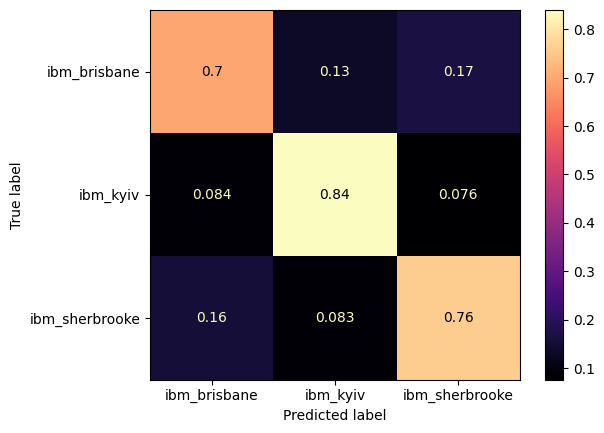

In [98]:
# qubit1Z_d5_state.pkl : qubit1Z_d5_{backend}_transpiled.qpy (at time of creation)
json_file = 'data/json/qubit1Z_d5_results.json'
df = json_to_expanded_df(json_file, d=5)
clf, updated_df, y_test, y_pred = build_backend_classifier(df, d=5)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

Accuracy: 69.47%
Classification Report:
                precision    recall  f1-score   support

  ibm_brisbane       0.68      0.79      0.73      1484
      ibm_kyiv       0.70      0.64      0.67      1492
ibm_sherbrooke       0.71      0.65      0.68      1524

      accuracy                           0.69      4500
     macro avg       0.70      0.70      0.69      4500
  weighted avg       0.70      0.69      0.69      4500



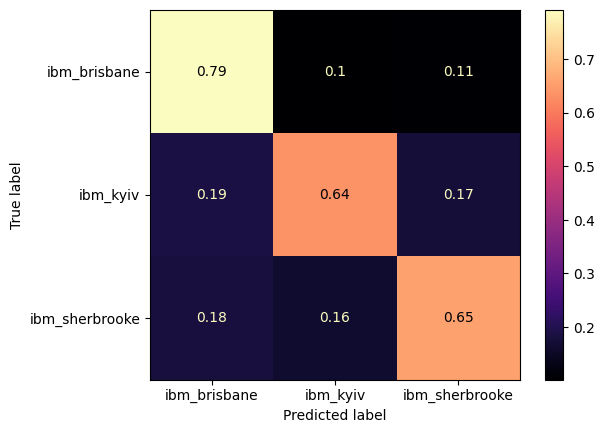

In [4]:
# qubit1Z_d5_{backend}_transpiled.qpy (approx 1 week after its creation)
json_file = 'data/json/qubit1Z_d5_2_results.json'
df = json_to_expanded_df(json_file, d=5)
clf, updated_df, y_test, y_pred = build_backend_classifier(df, d=5)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

Accuracy: 58.65%
Classification Report:
                precision    recall  f1-score   support

  ibm_brisbane       0.60      0.62      0.61      1485
 ibm_brisbane2       0.61      0.66      0.64      1511
      ibm_kyiv       0.58      0.53      0.56      1532
ibm_sherbrooke       0.55      0.53      0.54      1472

      accuracy                           0.59      6000
     macro avg       0.59      0.59      0.59      6000
  weighted avg       0.59      0.59      0.59      6000



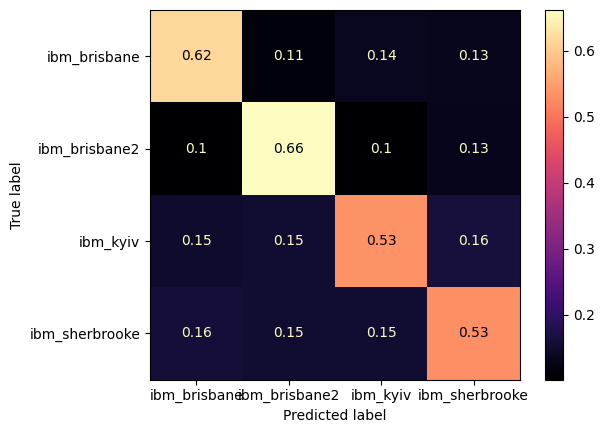

In [6]:
# qubit1Z_d5_{backend}_transpiled.qpy (approx 1 week after its creation)
json_file = 'data/json/qubit1Z_d5_b_results.json'
df = json_to_expanded_df(json_file, d=5)
clf, updated_df, y_test, y_pred = build_backend_classifier(df, d=5)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

In [54]:
json_file = 'data/json/qubit1Z_d5_combined_results.json'
df = json_to_expanded_df(json_file, d=5)
clf, updated_df, y_test, y_pred = build_backend_classifier(df, d=5)

Accuracy: 48.70%
Classification Report:
                   precision    recall  f1-score   support

 ibm_brisbane2_b1       0.48      0.47      0.47      1486
  ibm_brisbane_a1       0.49      0.56      0.52      1516
  ibm_brisbane_b1       0.49      0.53      0.51      1497
      ibm_kyiv_a1       0.55      0.78      0.64      1509
      ibm_kyiv_b1       0.42      0.30      0.35      1479
ibm_sherbrooke_a1       0.47      0.46      0.47      1498
ibm_sherbrooke_b1       0.45      0.30      0.36      1515

         accuracy                           0.49     10500
        macro avg       0.48      0.49      0.48     10500
     weighted avg       0.48      0.49      0.48     10500



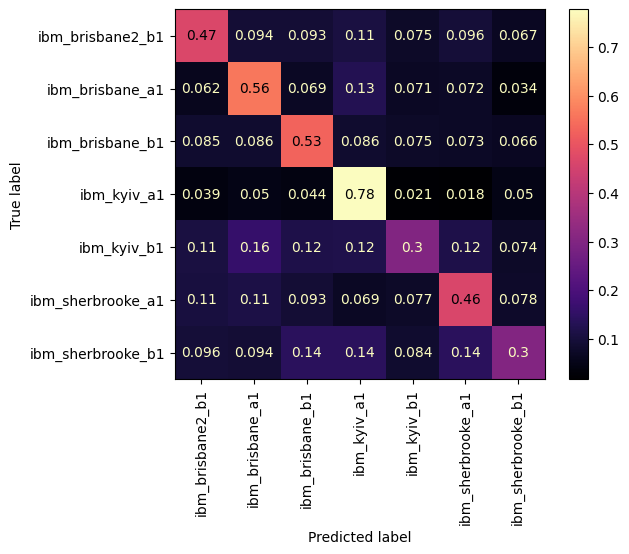

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')
plt.xticks(rotation=90)
plt.savefig('qubit1Z_d5_combined_matrix_diffmaps.png', dpi=300, bbox_inches='tight')

In [9]:
json_file = 'data/json/qubit1Z_d5_combined_results.json'
df = json_to_expanded_df(json_file, d=5)
#clf, df, y_test, y_pred = build_binary_backend_classifier(df, expected_readout=0, d=5, target_backend='ibm_brisbane_a1')

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [11]:
def build_svm_classifier(df, target_backend, expected_readout=0, d=5, adjust_threshold=False, threshold=0.5):
    measure_bits = (d*d)-1

    df = df[df['backend'] != 'ibm_sherbrooke_a2'].copy()  # Ensure we're working on a copy
    df = df[df['backend'] != 'ibm_brisbane_a2'].copy()
    df = df[df['backend'] != 'ibm_kyiv_a2'].copy()

    # readout_match (1 if z_readout matches expected_readout, else 0)
    df['readout_match'] = (df['z_readout'] == expected_readout).astype(int)

    # index_flip (how many times each bit flips between rounds)
    index_flip_cols = [f'index_flip_{i}' for i in range(measure_bits)]
    df[index_flip_cols] = df.apply(lambda row: calculate_index_flip(row, measure_bits), axis=1, result_type='expand')

    # agreement (proportion of bits that agree across rounds)
    df['agreement'] = df.apply(lambda row: calculate_agreement(row, measure_bits), axis=1)

    # flip_errs (count of errors in the last measure_bits/2 bits of each round)
    df['flip_errs'] = df.apply(lambda row: calculate_flip_errs(row, measure_bits), axis=1)

    # Convert the 'backend' column to binary (1 for target_backend, 0 for others)
    df['binary_backend'] = (df['backend'] == target_backend).astype(int)

    # Check class distribution before resampling
    print("Class distribution before resampling:")
    print(df['binary_backend'].value_counts())

    # Select features for training (excluding original backend and count columns)
    X = df.drop(columns=['backend', 'count', 'binary_backend'])
    y = df['binary_backend']  # Binary target variable

    # Apply SMOTE to oversample the minority class (1)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Check class distribution after resampling
    print("Class distribution after resampling:")
    print(y_resampled.value_counts())

    # Split data using stratified sampling to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)

    # Ensure there are two classes present in training data
    print("Training set class distribution:", y_train.value_counts())
    print("Test set class distribution:", y_test.value_counts())

    if len(y_train.unique()) == 1:
        raise ValueError("Training set only contains one class. Check the distribution or increase dataset size.")

    # Create and train the SVM with class_weight='balanced'
    svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
    print('Created SVM...')
    svm.fit(X_train, y_train)
    print('\tFit SVM')

    # Get probability predictions
    y_proba = svm.predict_proba(X_test)[:, 1]  # Probability for the positive class

    # Apply custom threshold if needed
    if adjust_threshold:
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = svm.predict(X_test)

    print('Got y pred')
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Print evaluation metrics
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    return svm, df, y_test, y_pred

Class distribution before resampling:
binary_backend
0    30000
1     5000
Name: count, dtype: int64
Class distribution after resampling:
binary_backend
0    30000
1    30000
Name: count, dtype: int64
Training set class distribution: binary_backend
1    21000
0    21000
Name: count, dtype: int64
Test set class distribution: binary_backend
0    9000
1    9000
Name: count, dtype: int64
Created SVM...
	Fit SVM
Got y pred
Accuracy: 92.12%
ROC AUC: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      9000
           1       0.91      0.94      0.92      9000

    accuracy                           0.92     18000
   macro avg       0.92      0.92      0.92     18000
weighted avg       0.92      0.92      0.92     18000



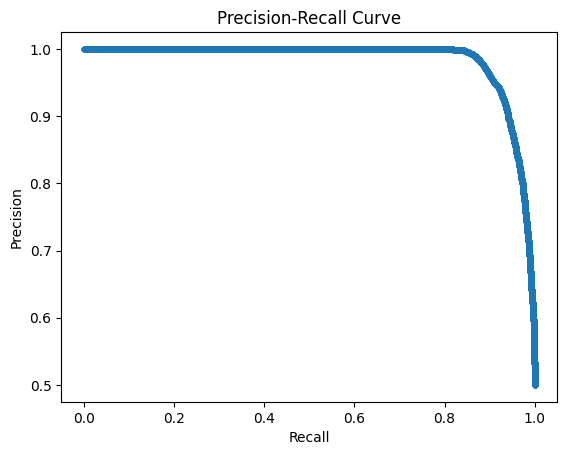

In [12]:
# Example usage:
svm, df, y_test, y_pred = build_svm_classifier(df, 'ibm_brisbane_a1', adjust_threshold=True, threshold=0.3)

Classifying for backend: ibm_brisbane_a1
Class distribution before resampling:
binary_backend
0    30000
1     5000
Name: count, dtype: int64
Class distribution after resampling:
binary_backend
0    30000
1    30000
Name: count, dtype: int64
Training set class distribution: binary_backend
1    21000
0    21000
Name: count, dtype: int64
Test set class distribution: binary_backend
0    9000
1    9000
Name: count, dtype: int64
Created SVM...
	Fit SVM
Got y pred
Accuracy: 93.12%
ROC AUC: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      9000
           1       0.98      0.88      0.93      9000

    accuracy                           0.93     18000
   macro avg       0.94      0.93      0.93     18000
weighted avg       0.94      0.93      0.93     18000



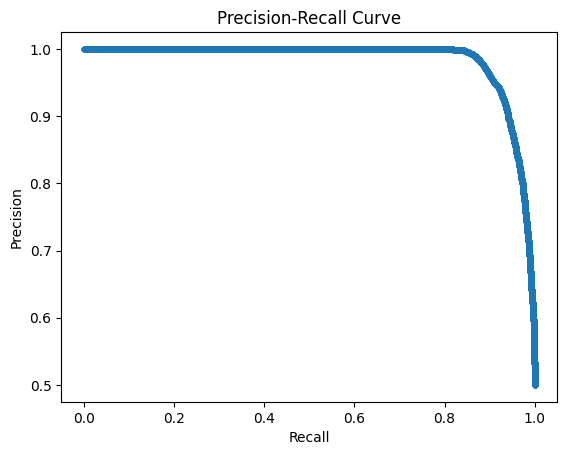

Accuracy for ibm_brisbane_a1: 93.12%
Classifying for backend: ibm_brisbane_b1
Class distribution before resampling:
binary_backend
0    30000
1     5000
Name: count, dtype: int64
Class distribution after resampling:
binary_backend
0    30000
1    30000
Name: count, dtype: int64
Training set class distribution: binary_backend
1    21000
0    21000
Name: count, dtype: int64
Test set class distribution: binary_backend
0    9000
1    9000
Name: count, dtype: int64
Created SVM...
	Fit SVM
Got y pred
Accuracy: 92.62%
ROC AUC: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      9000
           1       1.00      0.86      0.92      9000

    accuracy                           0.93     18000
   macro avg       0.93      0.93      0.93     18000
weighted avg       0.93      0.93      0.93     18000



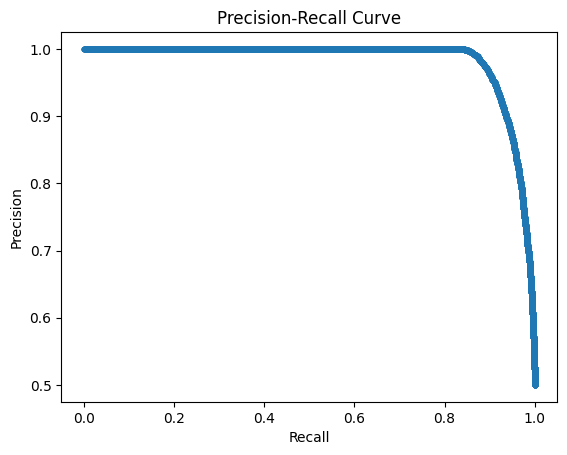

Accuracy for ibm_brisbane_b1: 92.62%
Classifying for backend: ibm_sherbrooke_a1
Class distribution before resampling:
binary_backend
0    30000
1     5000
Name: count, dtype: int64
Class distribution after resampling:
binary_backend
1    30000
0    30000
Name: count, dtype: int64
Training set class distribution: binary_backend
1    21000
0    21000
Name: count, dtype: int64
Test set class distribution: binary_backend
0    9000
1    9000
Name: count, dtype: int64
Created SVM...
	Fit SVM
Got y pred
Accuracy: 91.82%
ROC AUC: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      9000
           1       1.00      0.84      0.91      9000

    accuracy                           0.92     18000
   macro avg       0.93      0.92      0.92     18000
weighted avg       0.93      0.92      0.92     18000



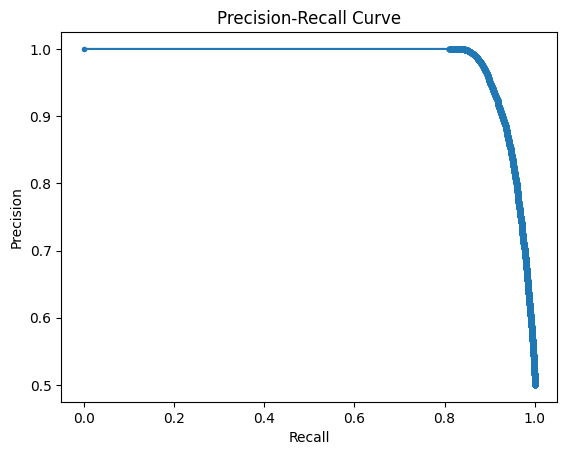

Accuracy for ibm_sherbrooke_a1: 91.82%
Classifying for backend: ibm_sherbrooke_b1
Class distribution before resampling:
binary_backend
0    30000
1     5000
Name: count, dtype: int64
Class distribution after resampling:
binary_backend
0    30000
1    30000
Name: count, dtype: int64
Training set class distribution: binary_backend
1    21000
0    21000
Name: count, dtype: int64
Test set class distribution: binary_backend
0    9000
1    9000
Name: count, dtype: int64
Created SVM...
	Fit SVM
Got y pred
Accuracy: 91.81%
ROC AUC: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      9000
           1       1.00      0.84      0.91      9000

    accuracy                           0.92     18000
   macro avg       0.93      0.92      0.92     18000
weighted avg       0.93      0.92      0.92     18000



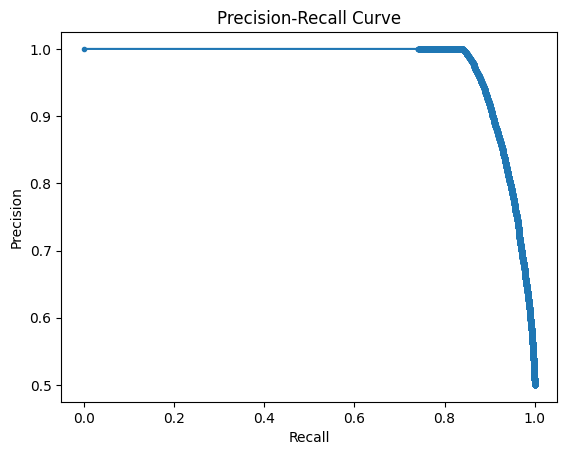

Accuracy for ibm_sherbrooke_b1: 91.81%
Classifying for backend: ibm_kyiv_a1
Class distribution before resampling:
binary_backend
0    30000
1     5000
Name: count, dtype: int64
Class distribution after resampling:
binary_backend
0    30000
1    30000
Name: count, dtype: int64
Training set class distribution: binary_backend
1    21000
0    21000
Name: count, dtype: int64
Test set class distribution: binary_backend
0    9000
1    9000
Name: count, dtype: int64
Created SVM...
	Fit SVM
Got y pred
Accuracy: 94.02%
ROC AUC: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      9000
           1       0.96      0.92      0.94      9000

    accuracy                           0.94     18000
   macro avg       0.94      0.94      0.94     18000
weighted avg       0.94      0.94      0.94     18000



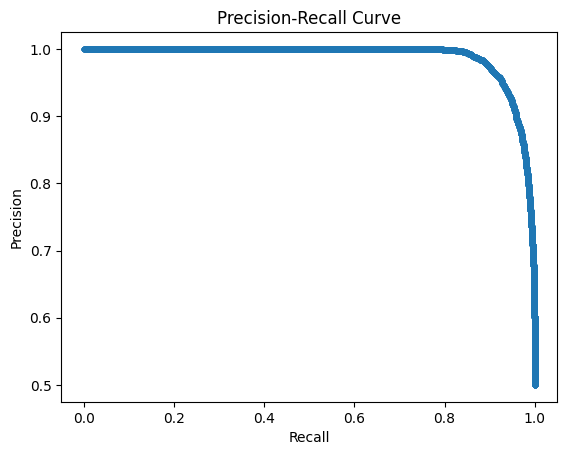

Accuracy for ibm_kyiv_a1: 94.02%
Classifying for backend: ibm_kyiv_b1
Class distribution before resampling:
binary_backend
0    30000
1     5000
Name: count, dtype: int64
Class distribution after resampling:
binary_backend
0    30000
1    30000
Name: count, dtype: int64
Training set class distribution: binary_backend
1    21000
0    21000
Name: count, dtype: int64
Test set class distribution: binary_backend
0    9000
1    9000
Name: count, dtype: int64
Created SVM...
	Fit SVM
Got y pred
Accuracy: 91.82%
ROC AUC: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      9000
           1       1.00      0.84      0.91      9000

    accuracy                           0.92     18000
   macro avg       0.93      0.92      0.92     18000
weighted avg       0.93      0.92      0.92     18000



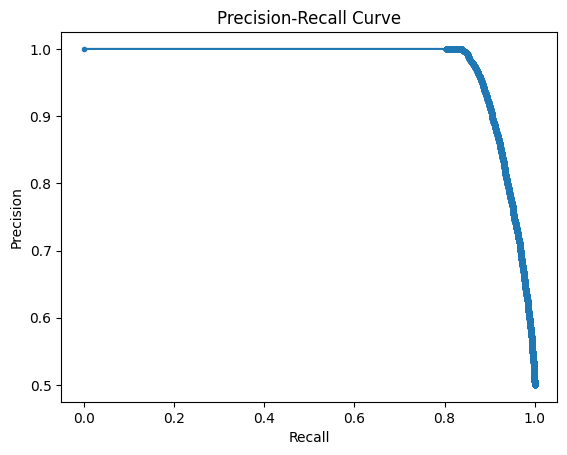

Accuracy for ibm_kyiv_b1: 91.82%


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

def get_backend_results(df, backend, suffix, d=5):
    target_backend = f'{backend}{suffix}'
    print(f"Classifying for backend: {target_backend}")
    # Use build_svm_classifier instead of build_binary_backend_classifier
    clf, df, y_test, y_pred = build_svm_classifier(df, target_backend=target_backend, expected_readout=0, d=d)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {target_backend}: {accuracy * 100:.2f}%")
    
    return clf, y_test, y_pred

# Define the backends and suffixes
backends = ['ibm_brisbane', 'ibm_sherbrooke', 'ibm_kyiv']
suffixes = ['_a1', '_b1']

# Store results
results = []

# Load your dataset
json_file = 'data/json/qubit1Z_d5_combined_results.json'
df = json_to_expanded_df(json_file, d=5)

# Loop through backends and suffixes
for backend in backends:
    for suffix in suffixes:
        clf, y_test, y_pred = get_backend_results(df, backend, suffix, d=5)
        results.append({
            'backend': f'{backend}{suffix}',
            'clf': clf,
            'y_test': y_test,
            'y_pred': y_pred
        })

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices(results):
    plt.figure(figsize=(15, 10))
    
    for i, result in enumerate(results):
        plt.subplot(3, 3, i + 1)
        cm = confusion_matrix(result['y_test'], result['y_pred'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='magma', ax=plt.gca(), colorbar=False)
        plt.title(result['backend'])
    
    plt.tight_layout()
    plt.savefig('qubit1Z_d5_binary_smote.png', dpi=300, bbox_inches='tight')
    plt.show()


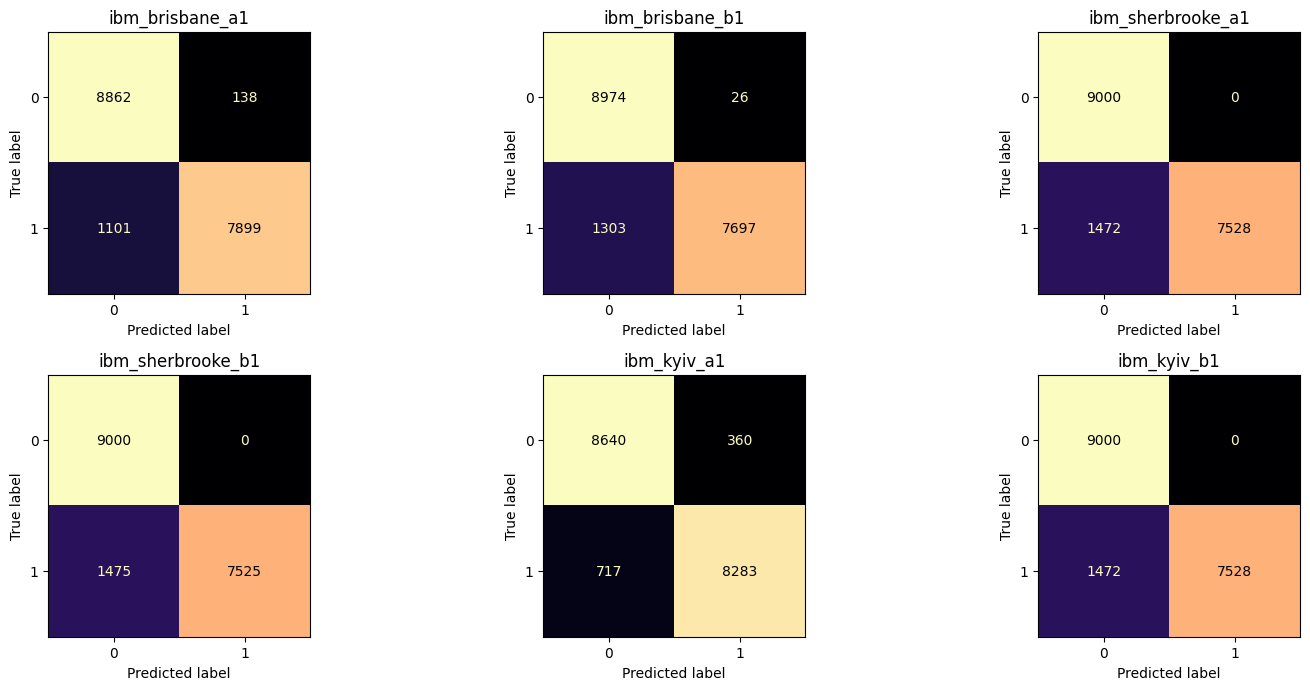

In [15]:
plot_confusion_matrices(results)

In [51]:
binary_combo_df

,backend,clf,y_test,y_pred
0,ibm_brisbane_a1,"(DecisionTreeClassifier(max_features='sqrt', r...",33553 0 9427 1 199 0 12447 0 39...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ibm_brisbane_a2,"(DecisionTreeClassifier(max_features='sqrt', r...",33553 0 9427 0 199 0 12447 0 39...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ibm_brisbane_b1,"(DecisionTreeClassifier(max_features='sqrt', r...",33553 1 9427 0 199 0 12447 0 39...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ibm_sherbrooke_a1,"(DecisionTreeClassifier(max_features='sqrt', r...",33553 0 9427 0 199 1 12447 0 39...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ibm_sherbrooke_a2,"(DecisionTreeClassifier(max_features='sqrt', r...",33553 0 9427 0 199 0 12447 0 39...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,ibm_sherbrooke_b1,"(DecisionTreeClassifier(max_features='sqrt', r...",33553 0 9427 0 199 0 12447 0 39...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,ibm_kyiv_a1,"(DecisionTreeClassifier(max_features='sqrt', r...",33553 0 9427 0 199 0 12447 1 39...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,ibm_kyiv_a2,"(DecisionTreeClassifier(max_features='sqrt', r...",33553 0 9427 0 199 0 12447 0 39...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,ibm_kyiv_b1,"(DecisionTreeClassifier(max_features='sqrt', r...",33553 0 9427 0 199 0 12447 0 39...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
res

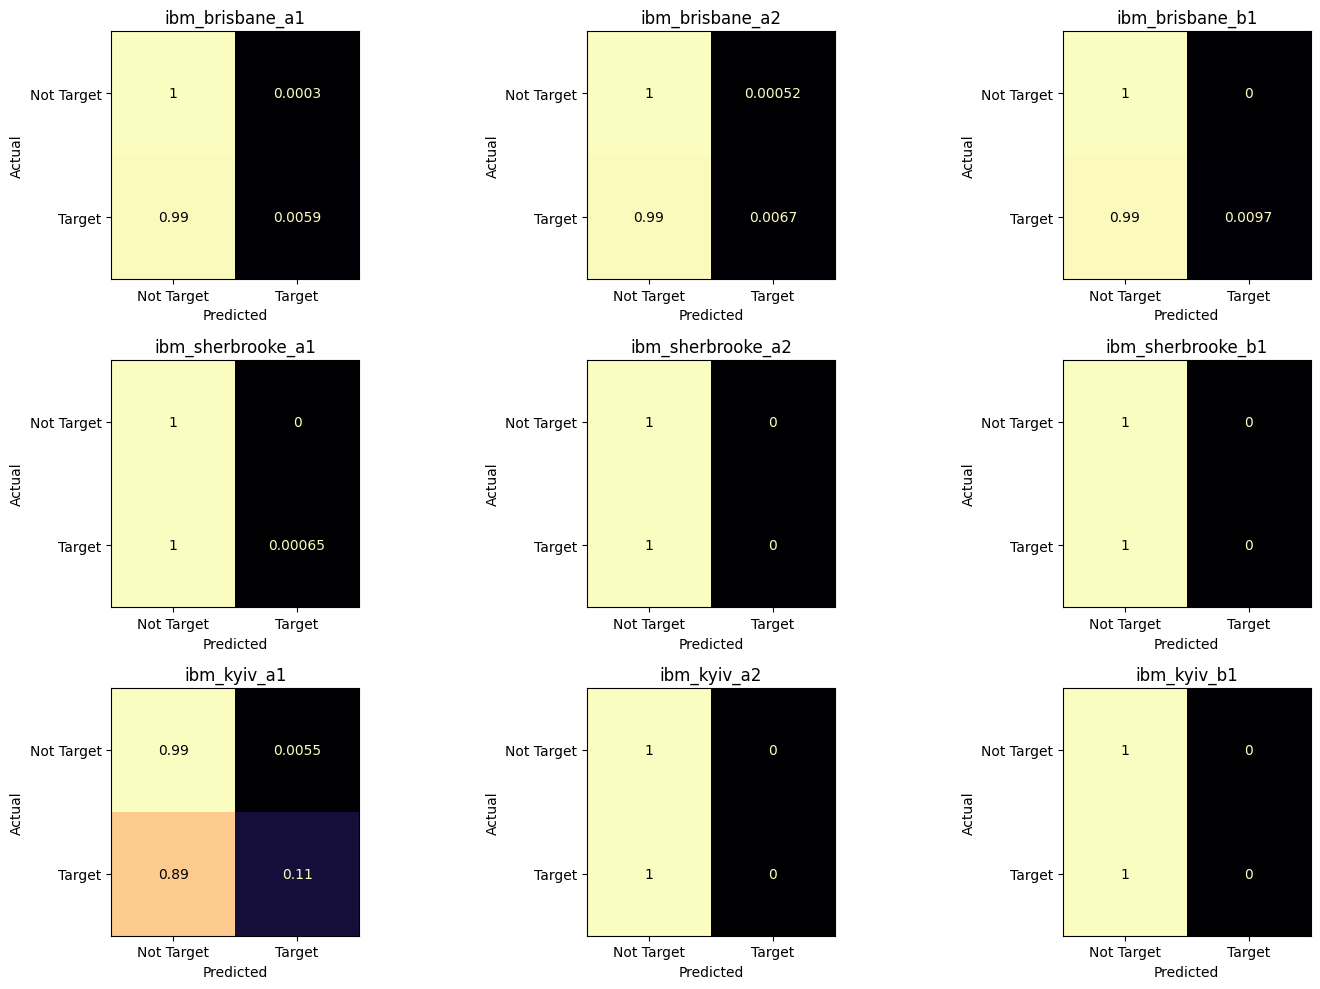

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrices(results):
    plt.figure(figsize=(15, 10))
    
    for i, result in enumerate(results):
        plt.subplot(3, 3, i + 1)
        
        # Compute confusion matrix and normalize by row (true labels)
        cm = confusion_matrix(result['y_test'], result['y_pred'], normalize='true')  # Normalized by true class count
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        
        # Plot with magma color map
        disp.plot(cmap='magma', ax=plt.gca(), colorbar=False)
        
        plt.title(result['backend'])
        plt.gca().set_xticks([0, 1], labels=['Not Target', 'Target'])
        plt.gca().set_yticks([0, 1], labels=['Not Target', 'Target'])
        plt.gca().set_xlabel('Predicted')
        plt.gca().set_ylabel('Actual')
    
    plt.tight_layout()
    plt.savefig('qubit1Z_d5_binary_norm.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the plotting function
plot_confusion_matrices(results)


In [47]:
df

,backend,bit_0_round_0,bit_1_round_0,bit_2_round_0,bit_3_round_0,bit_4_round_0,bit_5_round_0,bit_6_round_0,bit_7_round_0,bit_8_round_0,...,index_flip_17,index_flip_18,index_flip_19,index_flip_20,index_flip_21,index_flip_22,index_flip_23,agreement,flip_errs,binary_backend
0,ibm_sherbrooke_a1,0,1,0,1,1,0,0,0,1,...,0,0,0,2,1,2,1,0.250000,12,0
1,ibm_sherbrooke_a1,1,1,0,0,0,1,0,0,0,...,2,0,0,0,2,1,0,0.291667,16,0
2,ibm_sherbrooke_a1,0,0,1,1,1,1,0,0,0,...,1,0,2,1,0,0,1,0.375000,12,0
3,ibm_sherbrooke_a1,1,0,0,1,1,1,1,0,0,...,1,2,2,0,0,1,0,0.333333,14,0
4,ibm_sherbrooke_a1,0,1,0,0,1,0,0,1,0,...,1,0,2,1,0,1,2,0.291667,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,ibm_sherbrooke_b1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0.583333,12,0
49996,ibm_sherbrooke_b1,1,0,0,0,1,1,0,0,0,...,0,1,2,1,0,1,2,0.250000,12,0
49997,ibm_sherbrooke_b1,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0.250000,14,0
49998,ibm_sherbrooke_b1,0,0,0,1,0,0,0,0,1,...,2,2,1,0,2,0,1,0.208333,17,0


In [46]:
def plot_roc_curves(results, df):
    plt.figure(figsize=(10, 7))

    # Exclude columns not used during training
    X = df.drop(columns=['backend', 'count', 'binary_backend'])  # Adjust this to exclude target columns

    for result in results:
        # Get predicted probabilities for the positive class
        y_probs = result['clf'].predict_proba(X)[:, 1]

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(result['y_test'], y_probs)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{result["backend"]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Backends and Suffixes')
    plt.legend(loc="lower right")
    plt.show()

# Call the plotting function
plot_roc_curves(results, df)


ValueError: Found input variables with inconsistent numbers of samples: [15000, 50000]

<Figure size 1000x700 with 0 Axes>

- increase # of mappings to classify
- classify based on "older" transpilations / qpys
- change to binary classification
- mappings would only matter for qPuf, train one classifier per mapping

- rerun saved transpilations from d=5 tomorrow, next week
- implement arbitrary mapping?
- generate confusion matrix across machines and mappings
- gernerate a new classifier per mapping => you expect to know which mapping you're working with
    - pull the classifier that you generated for that backend & mapping
    - ex: have brisbane mapping a, everything is labeled as brisbane_a or not

```python
for backend in backends:
    for mapping_label in ["a", "b", "c"]:
        random_layout = np.random.permutation(backend.num_qubits)[
            : qc.num_qubits
        ]
        qc_transpiled = transpile(qc, backend, initial_layout=random_layout)
```